In [327]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/train_processed.csv')

In [304]:
sum(df['PoolArea'] > 0) / len(df)

0.004794520547945206

In [4]:
# Normalize the features

feats = list(set(df.columns) - set(['logSalePrice', 'SalePrice']))
df_normalized = df.copy()
df_normalized[feats] = (df[feats] - df[feats].mean()) / df[feats].std()
# df_normalized['logSalePrice'] = df['logSalePrice']
df_normalized['SalePrice'] = df['SalePrice'] / 1000000  # convert the unit to millions

In [117]:
def train_and_predict(
    df, feats, target, is_log_transformed=True,
    alphas=10 ** np.arange(-3.5, -2.8, 0.01),
    random_state=1000
):
    
    # Train-test split. Use 30% as testing data
    X_train, X_test, y_train, y_test = train_test_split(
        df[feats], df[target], test_size=0.3, random_state=random_state)

    # Lasso cross-validation
    lasso_cv = LassoCV(cv=10, random_state=random_state, alphas=alphas, n_jobs=-1)
    lasso_cv.fit(X_train, y_train)

    # Create a data frame to store how MSE changes with alpha (regularization strength)
    mse_path_df = pd.DataFrame({
        'alpha': lasso_cv.alphas_,
        'mse': np.mean(lasso_cv.mse_path_, axis=1)
    })

    # Predict on test data
    pred_test = lasso_cv.predict(X_test)
    
    # If log transform is used, we transform the data back to the original unit
    if is_log_transformed:
        pred_test = np.exp(pred_test) / 1000000  # in million dollar
        y_test = np.exp(y_test) / 1000000  # in million dollar
    
    # Calculate RMSE and MAPE
    rmse = np.sqrt(np.mean(np.square(pred_test - y_test)))
    mape = np.mean(np.abs(pred_test - y_test) / y_test)
    
    return {
        'mse_path': mse_path_df,
        'pred_test': pred_test,
        'X_test': X_test,  # return X_test for debugging purpose
        'y_test': y_test,
        'rmse': rmse,
        'mape': mape,
        'lasso_cv': lasso_cv  # store the whole lasso_cv object for easier exploration later
    }

In [6]:
def plot_results(res):
    plt.figure(figsize=(10, 7))
    
    # Scatter plot of the prediction
    plt.subplot(221)
    plt.plot(res['pred_test'], res['y_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('True Sale Price')
    
    # use get_xlim for both x and y to draw "x=y" line
    plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim())
    
    # Residual plot
    plt.subplot(222)
    plt.plot(res['pred_test'], res['y_test'] - res['pred_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('Residual')
    
    # plot a horizontal line
    plt.plot(plt.gca().get_xlim(), [0, 0])

    # LASSO: mse vs penalty strength
    plt.subplot(212)
    plt.plot(res['mse_path']['alpha'], res['mse_path']['mse'], '.-')
    plt.xlabel('Penalty Strength')
    plt.ylabel('MSE')
    plt.grid()
    print('Test RMSE: {:.3f} million, or {:.2f}k'.format(res['rmse'], res['rmse'] * 1000))
    print('Test MAPE: {:.2%}'.format(res['mape']))
    

## Use log price as the target

In [126]:
res = train_and_predict(df_normalized, feats, 'logSalePrice', is_log_transformed=True)

Test RMSE: 0.032 million, or 32.17k
Test MAPE: 9.69%


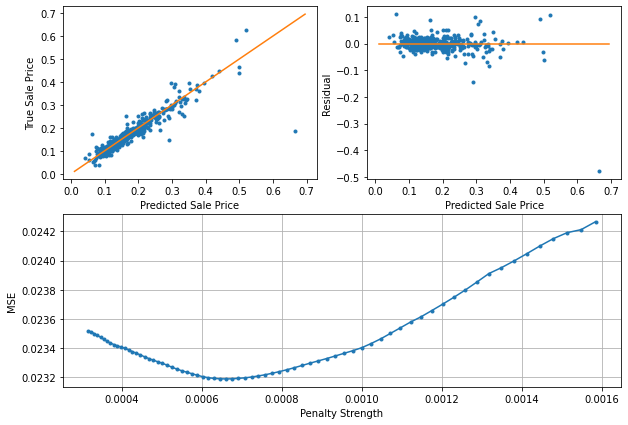

In [127]:
plot_results(res)

## Use price directly as the target

In [124]:
res2 = train_and_predict(df_normalized, feats, 'SalePrice', is_log_transformed=False,
                         alphas=10 ** np.arange(-4, -2, 0.01))

Test RMSE: 0.032 million, or 32.31k
Test MAPE: 11.29%


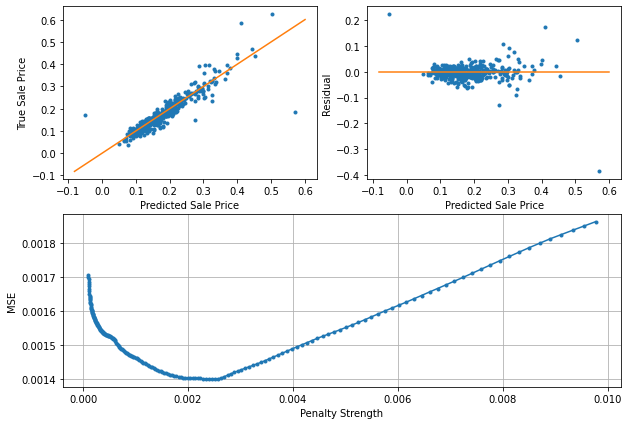

In [125]:
plot_results(res2)

## Analyze the selected features

In [194]:
feat_coef_df = pd.DataFrame({
    'feat_name': res['lasso_cv'].feature_names_in_,
    'coef': res['lasso_cv'].coef_,
    'abs_coef': np.abs(res['lasso_cv'].coef_)
})

In [195]:
# Sort the features based on the absolute value of the coefficients
feat_coef_df = feat_coef_df.sort_values(by='abs_coef', ascending=False)

### Feature Importance

* Use absolute coefficient as a way to measure the importance of the features (Note: the features are normalized)

* Most other top features look reasonable.

    * GrLivArea: the total living area is important, which is in line with our intuition
    
    * Zoning: several zoning variables are important, which is also reasonable
    
* However, "PoolArea" and "PoolQC_Not exist" has the largest coefficients.

    * Maybe the penalty strength is not big enough. However, the penalty strength is chosen by cross-validation. This model has the best accuracy. We should not trust the low-accuracy models, because it could just because the model selected the wrong features so it has the low accuracy.
    
    * Maybe the model is not stable in terms of the selected features in some scenarios.
    
        * Sparse models are not stable! http://users.ece.utexas.edu/~cmcaram/pubs/XuCaramanisMannor.NFL.pdf
        
        * We can verify if the coefficients are stable by running the algorithm multiple times with different random seeds.

#### Feature importance of the first run of the LASSO

* Pool Area and PoolQC_Not exist are very important

In [196]:
feat_coef_df.head(10)

,feat_name,coef,abs_coef
228,PoolArea,0.198472,0.198472
72,PoolQC_Not exist,0.177289,0.177289
207,GrLivArea,0.152244,0.152244
13,MSZoning_RL,0.133892,0.133892
33,LotArea,0.112457,0.112457
132,MSZoning_RM,0.102475,0.102475
61,GrLivArea*LotArea,-0.101004,0.101004
51,MSZoning_FV,0.068560,0.068560
88,PoolQC_Gd,-0.050476,0.050476
163,YearBuilt_sq,0.047922,0.047922


In [197]:
def add_feat_type(feat_coef_df):
    feat_coef_df['feat_type'] = 'Others'
    feat_coef_df['feat_type'] = np.where(
        feat_coef_df['feat_name'].apply(lambda x: 'Pool' in x),
        'Pool', feat_coef_df['feat_type']
    )
    
    feat_coef_df['feat_type'] = np.where(
        feat_coef_df['feat_name'].apply(lambda x: ('Area' in x and 'Pool' not in x) or ('SF' in x) or ('GarageCars' == x)),
        'Area / Size', feat_coef_df['feat_type']
    )
    
    feat_coef_df['feat_type'] = np.where(
        feat_coef_df['feat_name'].apply(lambda x: 'Zoning' in x or 'Neighborhood' in x),
        'Location', feat_coef_df['feat_type']
    )
    
    return feat_coef_df

In [198]:
feat_coef_df = add_feat_type(feat_coef_df)

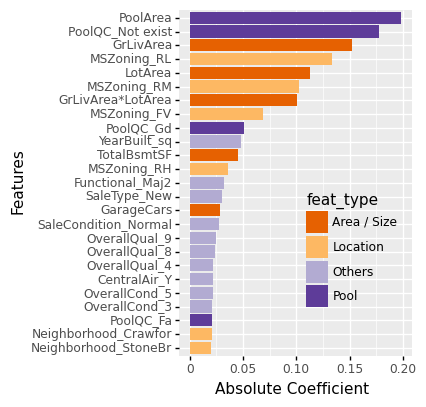

<ggplot: (8738964705247)>

In [199]:
(
    p9.ggplot(
        feat_coef_df.head(25),
        p9.aes(x='reorder(feat_name, abs_coef)', y='abs_coef', fill='feat_type'))
    + p9.geom_bar(stat='identity')
    + p9.ylab('Absolute Coefficient')
    + p9.xlab('Features')
    + p9.coords.coord_flip()
    + p9.scale_fill_brewer(type='div', palette=4)
    + p9.theme(figure_size=(3,4.5), legend_position=(0.7,0.35), legend_background=p9.element_blank())
)

In [200]:
feat_coef_df[
    feat_coef_df.apply(lambda x: 'Pool' in x['feat_name'], axis=1)
]

,feat_name,coef,abs_coef,feat_type
228,PoolArea,0.198472,0.198472,Pool
72,PoolQC_Not exist,0.177289,0.177289,Pool
88,PoolQC_Gd,-0.050476,0.050476,Pool
182,PoolQC_Fa,-0.020792,0.020792,Pool


In [201]:
df['PoolQC_Gd'].value_counts()

0    1457
1       3
Name: PoolQC_Gd, dtype: int64

## Stability of the coefficients

* Run the algorithm multiple times to assess the stability of the model coefficients

In [171]:
res_stability = []
for i in range(100):
    print(i, end=',', flush=True)
    
    # Use different random seed to run the whole training and prediction process
    res_stability.append(
        train_and_predict(df_normalized, feats, 'logSalePrice', is_log_transformed=True, random_state=1000 + i*100)
    )

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [202]:
feat_coef_repeated_df = pd.DataFrame()

# Gather the result for multiple runs of the LASSO
for i in range(100):
    current_res = res_stability[i]
    
    temp_df = pd.DataFrame({
            'run_id': i,
            'feat_name': current_res['lasso_cv'].feature_names_in_,
            'coef': current_res['lasso_cv'].coef_,
            'abs_coef': np.abs(current_res['lasso_cv'].coef_)
    })
    
    feat_coef_repeated_df = feat_coef_repeated_df.append(temp_df)

# Aggregate the feature coefficients
feat_coef_summary_df = feat_coef_repeated_df.groupby('feat_name').agg({
    'coef': [np.mean, np.min, np.max],
    'abs_coef': [np.mean, np.min, np.max]
})
feat_coef_summary_df.columns = [
    'coef_mean', 'coef_min', 'coef_max',
    'abs_coef_mean', 'abs_coef_min', 'abs_coef_max']
feat_coef_summary_df.sort_values(by='abs_coef_mean', ascending=False, inplace=True)
feat_coef_summary_df.reset_index(inplace=True)
feat_coef_summary_df['rank'] = np.arange(1, len(feat_coef_summary_df) + 1)

feat_coef_summary_df = add_feat_type(feat_coef_summary_df)

#### Now, the mean coefficients from multiple run is more stable

* PoolArea ranks # 23

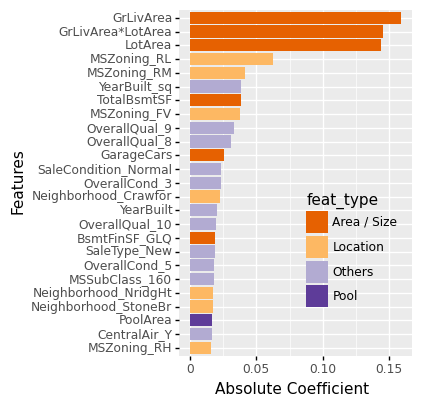

<ggplot: (8738949393131)>

In [203]:
(
    p9.ggplot(
        feat_coef_summary_df.head(25),
        p9.aes(x='reorder(feat_name, abs_coef_mean)', y='abs_coef_mean', fill='feat_type'))
    + p9.geom_bar(stat='identity')
    + p9.ylab('Absolute Coefficient')
    + p9.xlab('Features')
    + p9.coords.coord_flip()
    + p9.scale_fill_brewer(type='div', palette=4)
    + p9.theme(figure_size=(3,4.5), legend_position=(0.7,0.35), legend_background=p9.element_blank())
)

In [204]:
feat_coef_summary_df.head(30)

,feat_name,coef_mean,coef_min,coef_max,abs_coef_mean,abs_coef_min,abs_coef_max,rank,feat_type
0,GrLivArea,0.158932,0.119831,0.195995,0.158932,0.119831,0.195995,1,Area / Size
1,GrLivArea*LotArea,-0.144987,-0.277138,0.000000,0.144987,0.000000,0.277138,2,Area / Size
2,LotArea,0.143715,0.013611,0.261672,0.143715,0.013611,0.261672,3,Area / Size
3,MSZoning_RL,0.062636,0.004599,0.206592,0.062636,0.004599,0.206592,4,Location
4,MSZoning_RM,0.041624,-0.004872,0.159186,0.041760,0.000000,0.159186,5,Location
5,YearBuilt_sq,0.038786,0.000000,0.081807,0.038786,0.000000,0.081807,6,Others
6,TotalBsmtSF,0.038271,0.015946,0.069777,0.038271,0.015946,0.069777,7,Area / Size
7,MSZoning_FV,0.038118,0.000000,0.106662,0.038118,0.000000,0.106662,8,Location
8,OverallQual_9,0.032904,0.024998,0.040838,0.032904,0.024998,0.040838,9,Others
9,OverallQual_8,0.030946,0.019789,0.040928,0.030946,0.019789,0.040928,10,Others


### Focus on a few features' ranking

### YrSold

* We thought there was a financial crisis around 2008 and 2009. The house price should be much lower during this time. And this could be reflected in the coefficient for YrSold.

* However, it is not the case, so we double check with zillow's house price index

    * IA was not impacted too much by the financial crisis.

In [208]:
YrSold_feat_coef_df = feat_coef_repeated_df[['YrSold' in x for x in feat_coef_repeated_df.feat_name]]

In [221]:
YrSold_feat_coef_df['feat_name'].apply(lambda x: x[-4:])

58     2007
124    2008
225    2010
252    2009
58     2007
       ... 
252    2009
58     2007
124    2008
225    2010
252    2009
Name: feat_name, Length: 400, dtype: object

In [225]:
YrSold_feat_coef_df['year'] = YrSold_feat_coef_df['feat_name'].apply(lambda x: x[-4:])

In [226]:
YrSold_feat_coef_df

,run_id,feat_name,coef,abs_coef,year
58,0,YrSold_2007,0.000000,0.000000,2007
124,0,YrSold_2008,-0.000000,0.000000,2008
225,0,YrSold_2010,0.003262,0.003262,2010
252,0,YrSold_2009,-0.002822,0.002822,2009
58,1,YrSold_2007,-0.000000,0.000000,2007
...,...,...,...,...,...
252,98,YrSold_2009,-0.001975,0.001975,2009
58,99,YrSold_2007,-0.000383,0.000383,2007
124,99,YrSold_2008,0.002250,0.002250,2008
225,99,YrSold_2010,-0.002574,0.002574,2010


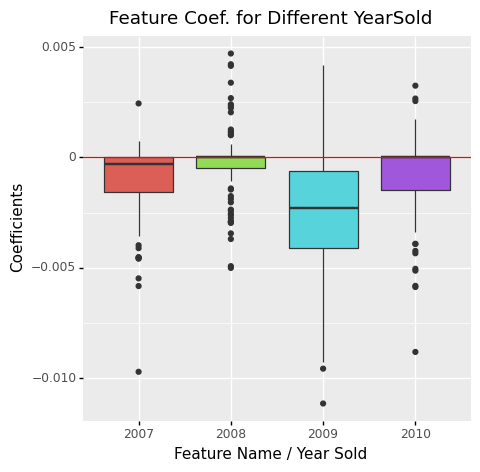

<ggplot: (8738944531794)>

In [361]:
# Note: baseline is 2006, which is not encoded as a new feature
(
    p9.ggplot(YrSold_feat_coef_df, p9.aes('year', 'coef', fill='year'))
    + p9.geom_boxplot()
    + p9.geom_hline(yintercept=0, color='r')
    + p9.xlab('Feature Name / Year Sold')
    + p9.ylab('Coefficients')
    + p9.ggtitle('Feature Coef. for Different YearSold')
    + p9.theme(figure_size=(5, 5), legend_position='none')
)

In [248]:
feat_coef_df[feat_coef_df['abs_coef'] > 0]

,feat_name,coef,abs_coef,feat_type
228,PoolArea,0.198472,0.198472,Pool
72,PoolQC_Not exist,0.177289,0.177289,Pool
207,GrLivArea,0.152244,0.152244,Area / Size
13,MSZoning_RL,0.133892,0.133892,Location
33,LotArea,0.112457,0.112457,Area / Size
...,...,...,...,...
186,Condition_Norm,0.000194,0.000194,Others
56,Fence_Not exist,-0.000143,0.000143,Others
191,GarageCond_Gd,0.000137,0.000137,Others
256,MasVnrType_None,0.000098,0.000098,Others


In [249]:
200 / 269

0.7434944237918215

#### Observations:

* The coef for YrSold_2009 is only slightly lower than the coef for other years. It seems the house market was not heavily impacted by the crisis.

In [250]:
from datetime import datetime

In [340]:
df_zillow = pd.read_csv('data/zillow_price_state.csv')

In [341]:
df_zillow_price_change = (
    df_zillow.loc[:, '2006-01-31':'2011-01-31']  # Only look at the years around the financial crisis
    .apply(lambda x: x/x['2006-01-31'] - 1, axis=1)  # Use 2006-01-31 price as the baseline of calculation
)

In [342]:
# Combine the price change data back to zillow data, and remove the original price data
df_zillow = pd.concat([df_zillow.iloc[:, :5], df_zillow_price_change], axis=1)

In [343]:

df_zillow = (
    df_zillow.melt(
        id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
        var_name='dt',
        value_name='price_change'
    )
)

df_zillow['dt'] = df_zillow['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

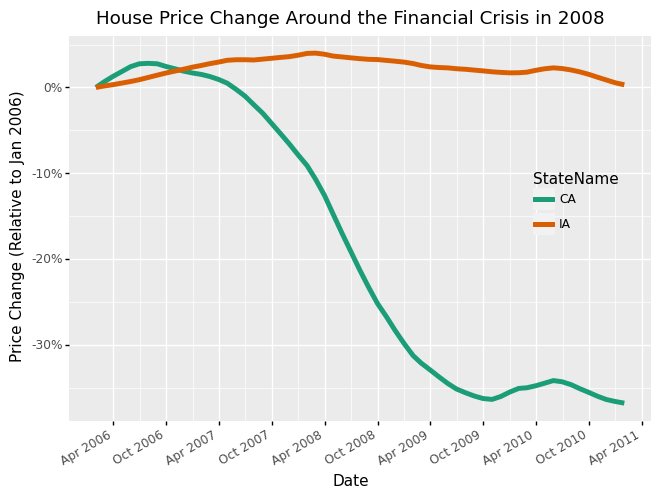

<ggplot: (8738952011325)>

In [363]:
(
    p9.ggplot(
        df_zillow[df_zillow['StateName'].isin(['IA', 'CA'])],
        p9.aes('dt', 'price_change', color='StateName')
    )
    + p9.geom_line(size=2)
    + p9.scale_x_datetime(breaks=date_breaks('6 months'), labels=date_format('%b %Y')) 
    + p9.scale_y_continuous(labels=lambda l: ['{:.0%}'.format(x) for x in l])
    + p9.scale_color_brewer(type='qual', palette=2)
    + p9.xlab('Date')
    + p9.ylab('Price Change (Relative to Jan 2006)')
    + p9.ggtitle('House Price Change Around the Financial Crisis in 2008')
    + p9.theme(
        figure_size=(7.5, 5),
        axis_text_x=p9.element_text(rotation=30, hjust=1),
        legend_position=(0.8, 0.55),
        legend_background=p9.element_blank()
    )
)

#### Observations:

* IA was not impacted, CA was impacted

### Condition

* Whether the house is near artery road --> high noise level

In [24]:
feat_coef_df[['Condition' in x and 'Sale' not in x for x in feat_coef_df.index]]

,coef_mean,coef_min,coef_max,abs_coef_mean,abs_coef_min,abs_coef_max,rank
feat_name,,,,,,,
Condition_Artery,-0.011277,-0.017707,-0.004940,0.011277,0.004940,0.017707,48
Condition_RRAe,-0.010395,-0.014560,-0.004593,0.010395,0.004593,0.014560,53
Condition_Norm,0.009754,-0.001113,0.023780,0.009814,0.000000,0.023780,57
Condition_Feedr,-0.008513,-0.014804,-0.001019,0.008513,0.001019,0.014804,64
Condition_PosN,-0.004285,-0.012491,0.000000,0.004285,0.000000,0.012491,97
Condition_RRNn,0.001902,-0.000963,0.006446,0.001981,0.000000,0.006446,166
Condition_RRNe,-0.001667,-0.005594,-0.000000,0.001667,0.000000,0.005594,190
Condition_PosA,-0.000068,-0.003594,0.006001,0.001302,0.000000,0.006001,208
Condition_RRAn,-0.000832,-0.004585,0.001777,0.001013,0.000000,0.004585,223
